In [51]:
%load_ext autoreload
%autoreload 2
from od.place import Place

import geopandas as gpd
import pandas as pd
import osmnx as ox

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Extract destinations from OSM land use

<Axes: >

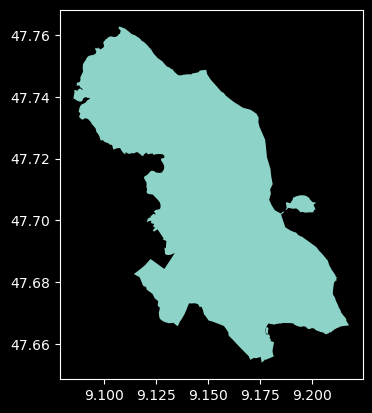

In [3]:
place_name = 'Konstanz, Germany'
city = Place(place_name)
city.get_tiles()
city.place.plot()

[OSM landuse](https://wiki.openstreetmap.org/wiki/Key:landuse?uselang=en)

In [43]:
# landuse classification 
landuse_dict = {
    'work': ['commercial', 'construction', 'industrial', 'retail', 'institutional', 'aquaculture', 'farmyard', 'port', 'quarry'],
    'leisure': ['fairground', 'retail', 'recreation_ground', 'religious', 'winter_sports'],
    'empty': ['allotments', 'farmland', 'paddy', 'animal_keeping', 'flowerbed', 'forest','grass', 'greenhouse_horticulture', 'meadow', 'orchard', 'plant_nursery', 'vineyard', 'village_green', 'greenfield', 'brownfield', 'landfill', 'cemetery', 'garages', 'military', 'railway']
}
# by empty, understand not much traffic flow

work_tags = {
    'landuse': landuse_dict['work'],
    'office': True,
    'shop': True,
    'healthcare': True
}

education_tags = {
    'landuse': 'education',
    'amenity': ['kindergarten','school','college','university']
}

leisure_tags = {
    'landuse': landuse_dict['leisure'],
    'shop': True,
    'leisure': True,
    'sport': True,
    'tourism': True,
}

empty_tags = {
    'landuse': landuse_dict['empty'],
    'natural': 'water'
    } 

In [44]:
places = {
    'work': ox.features_from_place(place_name, work_tags),
    'education': ox.features_from_place(place_name, education_tags),
    'leisure': ox.features_from_place(place_name, leisure_tags),
    'empty': ox.features_from_place(place_name, empty_tags),
}

<Axes: >

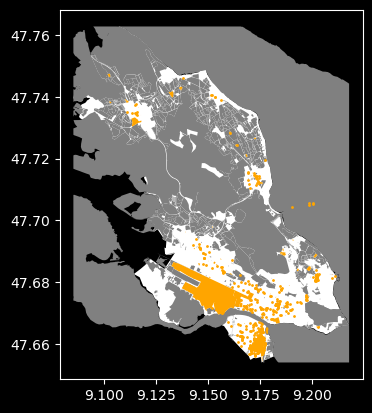

In [46]:
empty_places = gpd.clip(places['empty'], city.bbox)
ax = city.place.plot(color='white')
ax = empty_places.plot(ax=ax, zorder=1, color='gray')
places['work'].plot(ax=ax, zorder=2, color='orange', markersize=1)

In [7]:
# Area of a single hex tile in m²
# projection to cartesian system is needed to compute area
# https://epsg.io/6933
city.tiles.to_crs(epsg=6933)['geometry'][0].area #3035

706715.614454604

In [47]:
city.destination = city.tiles.copy()
points_area = 100 # m²
default_work_area = 500 # m²

for i, tile in city.destination.iterrows():
    for interest in places.keys():
        # clip places by hex tile
        local_places = gpd.clip(places[interest], tile['geometry']).copy()
        # compute interest area in tile
        area = 0
        nb_points = 0
        if len(local_places) != 0:
            # replace single points with a defined area
            nb_points = len(local_places[local_places['geometry'].geom_type=='Point'])
            area = local_places.to_crs(epsg=6933).area.sum()
        city.destination.loc[i, interest] = area + nb_points * points_area
        if interest=='work':
            city.destination.loc[i, interest] += default_work_area

In [40]:
city.destination.head()

,h3,geometry,work,leisure,empty
0,613044699973812223,"POLYGON ((9.17561 47.69788, 9.17383 47.69334, ...",500.000000,26312.772992,7.130446e+05
1,613044700456157183,"POLYGON ((9.13354 47.71732, 9.13176 47.71278, ...",500.000000,0.000000,6.930384e+05
2,613044699961229311,"POLYGON ((9.14865 47.70833, 9.14687 47.70379, ...",500.000000,0.000000,1.226220e+06
3,613044699896217599,"POLYGON ((9.17887 47.69034, 9.17708 47.68579, ...",22171.896952,54041.034311,5.731614e+05
4,613044700496003071,"POLYGON ((9.13236 47.74603, 9.13058 47.74149, ...",30080.426294,40884.498673,5.393515e+05


<Axes: >

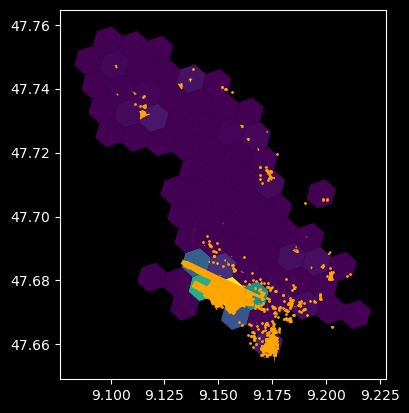

In [50]:
ax = city.destination.plot(column='work')
places['work'].plot(ax=ax, zorder=1, color='orange', markersize=1)

## Split population according to age, employment
### Get the city region

In [220]:
data_folder = '../data/'
nuts = gpd.read_file(data_folder+'nuts/NUTS_RG_01M_2021_4326.geojson')
age_df = pd.read_csv(data_folder+'age/age_nuts3_2022_clean.csv')
employment_df = pd.read_csv(data_folder+'employment_rate/employment_rate_nuts2_2022_clean.csv')

In [194]:
nuts3 = nuts[nuts['LEVL_CODE']==3][['id', 'geometry']]

In [197]:
# nuts regions that overlaps with the city
city_regions = nuts3.loc[nuts3.overlaps(city.place['geometry'][0]), ['id', 'geometry']]
city_regions

,id,geometry
606,DE138,"MULTIPOLYGON (((9.12858 47.84682, 9.12000 47.8..."
658,DE147,"POLYGON ((9.40941 47.82160, 9.41351 47.81979, ..."
897,CH057,"MULTIPOLYGON (((8.71772 47.69074, 8.72050 47.6..."


<Axes: >

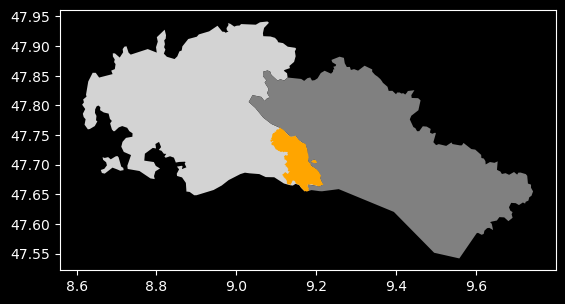

In [198]:
# due to precision differences, the city is overlapping with several regions instead of one 
# regions are defined according to cities boundaries so there should be one region assigned to a city

ax = nuts3[nuts3['id']=='DE138'].plot(color='lightgray')
ax = nuts3[nuts3['id']=='DE147'].plot(ax=ax, color='gray')
city.place.plot(ax=ax, color='orange')

In [190]:
# compute the intersection area and keep the bigger one
best_matching_index = city_regions.intersection(city.place['geometry'][0]).area.argmax()
city.nuts3_region = city_regions.iloc[best_matching_index]['id']

/tmp/ipykernel_66293/3610774092.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  best_matching_index = city_regions.intersection(city.place['geometry'][0]).area.argmax()


### Age distribution for this region

In [218]:
def df_to_percent(df, index):
    df = df.set_index(index)
    df = df.div(df.sum(axis=1), axis=0)
    return df.reset_index()

In [219]:
age_region = age_df[age_df['nuts3']==city.nuts3_region]
age_region = df_to_percent(age_region, 'nuts3')
age_region

,nuts3,under_20,between_20_64,over_64
0,DE138,0.187513,0.596934,0.215552


### Employment rate for this region

In [221]:
# note that nuts2 id is every character but the last one of nuts3
employment_region = employment_df[employment_df['nuts2']==city.nuts3_region[:-1]]
employment_region = df_to_percent(employment_region, 'nuts2')
employment_region

,nuts2,employment_rate_between_20_64,employment_rate_over_64
0,DE13,0.879202,0.120798


## OD matrix

In [251]:
city.load_population()

In [223]:
def col_to_percent(df, col):
    percent_col = (df[col]/df[col].sum())
    return percent_col

In [233]:
for interest in places.keys():
    city.destination[interest] = col_to_percent(city.destination, interest)

In [242]:
city.destination.head()

,h3,geometry,work,education,leisure,empty
0,613044699973812223,"POLYGON ((9.17561 47.69788, 9.17383 47.69334, ...",0.000227,0.000000,0.006762,0.020026
1,613044700456157183,"POLYGON ((9.13354 47.71732, 9.13176 47.71278, ...",0.000227,0.000000,0.000000,0.019464
2,613044699961229311,"POLYGON ((9.14865 47.70833, 9.14687 47.70379, ...",0.000227,0.000000,0.000000,0.034438
3,613044699896217599,"POLYGON ((9.17887 47.69034, 9.17708 47.68579, ...",0.010063,0.184156,0.013888,0.016097
4,613044700496003071,"POLYGON ((9.13236 47.74603, 9.13058 47.74149, ...",0.013652,0.000000,0.010507,0.015148


In [318]:
od_matrix = pd.DataFrame(columns=list(city.destination['h3']))

In [321]:
# for each tile (origin)
working_percentage = age_region['between_20_64']*employment_region['employment_rate_between_20_64'] + age_region['over_64']*employment_region['employment_rate_over_64']
for _, o_tile in city.gdf.iterrows():
    dest = city.destination.copy()
    dest = dest.set_index('h3')
    o_id = o_tile['h3']
    
    working_population = float(o_tile['population']*working_percentage)
    school_population = float(o_tile['population']*age_region['under_20'])
    leisure_population = float(o_tile['population']-working_population-school_population)
    
    dest['working_population'] = dest['work']*working_population
    dest['schooling_population'] = dest['education']*school_population
    dest['leisure_population'] = dest['leisure']*leisure_population
    
    dest[o_id] = dest['working_population'] + dest['schooling_population'] + dest['leisure_population']

    dest = dest.T # transpose
    moving_population = dest[dest.index==o_id]
    od_matrix = pd.concat([od_matrix, moving_population])

In [324]:
od_matrix.head()

,613044699973812223,613044700456157183,613044699961229311,613044699896217599,613044700496003071,613044700430991359,613044699988492287,613044706751807487,613044700535848959,613044699975909375,...,613044700531654655,613044700466642943,613044699906703359,613044699959132159,613044699894120447,613044699946549247,613044700493905919,613044700428894207,613044699998978047,613044699980103679
613044706791653375,0.248133,0.016376,0.016376,5.725784,1.345279,0.092141,22.067363,0.016376,0.70248,4.113354,...,0.600701,0.017256,0.501477,1.572221,0.017256,0.277135,0.055949,0.255284,5.221705,3.58121
613044706753904639,0.20078,0.013251,0.013251,4.633077,1.088546,0.074557,17.856034,0.013251,0.568419,3.328363,...,0.486063,0.013963,0.405775,1.272178,0.013963,0.224247,0.045271,0.206566,4.225196,2.897773
613044706749710335,0.001894,0.000125,0.000125,0.043708,0.010269,0.000703,0.168453,0.000125,0.005362,0.0314,...,0.004586,0.000132,0.003828,0.012002,0.000132,0.002116,0.000427,0.001949,0.03986,0.027337
613044706747613183,0.117437,0.00775,0.00775,2.709913,0.636697,0.043609,10.444096,0.00775,0.332471,1.946778,...,0.284301,0.008167,0.23734,0.744104,0.008167,0.131163,0.026479,0.120821,2.471341,1.694924
613044706221228031,0.337158,0.022251,0.022251,7.780073,1.827936,0.1252,29.984662,0.022251,0.954515,5.589137,...,0.816219,0.023448,0.681396,2.1363,0.023448,0.376565,0.076022,0.346875,7.095141,4.866071


In [325]:
# export
od_matrix.to_csv(data_folder+'od_matrix/first_od_matrix.csv')